## Gradient Boosting Out-of-Bag Estimates
Out-of-bag (OOB) estimates can be a useful heuristic to estimate the "optimal" number of boosting iterations. OOB estimates are almost identical to cross-validation estimates but they can be computed on-the-fly without the need for repeated model fitting.

OOB estimates are only available for Stochastic Gradient Boosting (i.e. `subsample < 1.0`), the estimates are derived from the improvement in loss based on the examples not included in the bootstrap sample. The OOB estimator is a perssimistic estimator of the true test loss, but remains a fairly good approximation for a small number of trees.

1. Generate the data

In [2]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

# Import the libraries
import matplotlib.pyplot as plt 
import numpy as np 
from scipy.special import expit 
from sklearn import ensemble
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold, train_test_split

# Generate the data 
n_samples = 1000
random_state = np.random.RandomState(13)
x1 = random_state.uniform(size=n_samples)
x2 = random_state.uniform(size=n_samples)
x3 = random_state.randint(0, 4, size=n_samples)

p = expit(np.sin(3 * x1) - 4 * x2 + x3)
y = random_state.binomial(1, p, size=n_samples)
X = np.c_[x1, x2, x3]
X = X.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=9)

2. Fit the classifier with out-of-bag estimates

In [3]:
# Train the classifier
params = {
    "n_estimators": 1200,
    "max_depth": 3,
    "subsample": 0.5,
    "learning_rate": 0.01,
    "min_samples_leaf": 1,
    "random_state": 3,
}
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print("Accuracy: {:.4}".format(accuracy))

Accuracy: 0.684


3. Calculate different estimators' loss

In [4]:
# Estimate loss
n_estimators = params["n_estimators"]
x = np.arange(n_estimators) + 1

# Compute deviance scores on X_test and y_test
def heldout_score(clf, X_test, y_test):
    score = np.zeros((n_estimators,), dtype=np.float64)
    for i, y_proba in enumerate(clf.staged_predict_proba(X_test)):
        score[i] = 2 * log_loss(y_test, y_proba[:,1])
    return score

# Compute cross-validation estimate loss
def cv_estimate(n_splits=None):
    cv = KFold(n_splits=n_splits)
    cv_clf = ensemble.GradientBoostingClassifier(**params)
    cv_scores = np.zeros((n_estimators,), dtype=np.float64)

    for train, test in cv.split(X_train, y_train):
        cv_clf.fit(X_train[train], y_train[train])
        cv_scores += heldout_score(cv_clf, X_train[test], y_train[test])
    cv_scores /= n_splits
    return cv_scores

# Estimate best n_estimator with cv
cv_score = cv_estimate(3)

# Compute best n_estimator for test data
test_score = heldout_score(clf, X_test, y_test)

# Negative cumulative sum of OOB improvements
cumsum = -np.cumsum(clf.oob_improvement_)

# min loss according to OOB
oob_best_iter = x[np.argmin(cumsum)]

# min loss according to test (normalize such that first loss is 0)
test_score -= test_score[0]
test_best_iter = x[np.argmin(test_score)]

# min loss according to cv (normalize such that first loss is 0)
cv_score -= cv_score[0]
cv_best_iter = x[np.argmin(cv_score)]

4. Plot the data

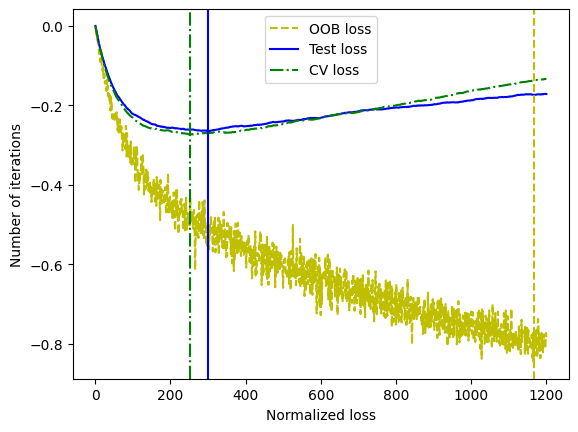

In [6]:
# Plot curves and vertical lines for best iterations
plt.plot(x, cumsum, label="OOB loss", color='y', linestyle="dashed")
plt.plot(x, test_score, label="Test loss", color='b', linestyle="solid")
plt.plot(x, cv_score, label="CV loss", color='g', linestyle="dashdot")
plt.axvline(x=oob_best_iter, color='y', linestyle="dashed")
plt.axvline(x=test_best_iter, color='b', linestyle="solid")
plt.axvline(x=cv_best_iter, color='g', linestyle="dashdot")

plt.legend(loc="upper center")
plt.xlabel("Normalized loss")
plt.ylabel("Number of iterations")

plt.show()